In [1]:
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
FONTSIZE = 16
LINESTYLE = (0,(4,4))
LINEWIDTH = 2.5
SAVE_FIG = True

RESERVATION = 'RES129065'

CELL_ORDER_RE_PATTERN = ".*ts_ms:(?P<ts>\d*) slice_metrics:(?P<metrics_dict>.*)"

cell_order_log_filename = '../data/cell-order-' + RESERVATION + '.log'

Cell-Order log line:

`2022-09-10 07:01:13,408 INFO     ts_ms:1662793273408 slice_metrics:{0: {'cur_slice_mask': '11111000000000000', 'dl_latency [msec]': 21.068701301700617, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 2.6001014999999996, 'dl_buffer [bytes]': 6610.4}, 1: {'cur_slice_mask': '00000111110000000', 'dl_latency [msec]': 8.969970247895116, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 0.784571775, 'dl_buffer [bytes]': 841.5}, 2: {'cur_slice_mask': '00000000001111100', 'dl_latency [msec]': 17.10698629155465, 'new_num_rbgs': 5, 'num_slice_users': 1, 'tx_brate downlink [Mbps]': 3.2608447499999995, 'dl_buffer [bytes]': 7144.95}}`


In [3]:
def read_cell_order_log(filename):
    retval = {}
    ts_min = None
    with open(filename,'r') as f:
        for line in f:
            if ('ts_ms' not in line):
                if ('slice-delay-budget-msec' in line):
                    print('==========')
                    print(line)
                continue

            log = re.match(CELL_ORDER_RE_PATTERN, line)
            ts = float(log.group('ts')) / 1000. # in sec
            metrics_dict = ast.literal_eval(log.group('metrics_dict'))

            if not ts_min:
                ts_min = ts

            for s_idx, metrics in metrics_dict.items():
                if s_idx not in list(retval):
                    retval[s_idx] = {'ts_sec':[], 
                                     'lat_msec': [], 
                                     'n_rbgs': [],
                                     'tx_mbps': [], 
                                     'buf_bytes': []}

                retval[s_idx]['ts_sec'].append( ts - ts_min )
                retval[s_idx]['lat_msec'].append( float(metrics['dl_latency [msec]']) )
                retval[s_idx]['n_rbgs'].append( int(metrics['new_num_rbgs']) )
                retval[s_idx]['tx_mbps'].append( float(metrics['tx_brate downlink [Mbps]']) )
                retval[s_idx]['buf_bytes'].append( float(metrics['dl_buffer [bytes]']) )

    for s_idx, s_data in retval.items():
        retval[s_idx]['ts_sec'] = np.array(s_data['ts_sec'])
        retval[s_idx]['lat_msec'] = np.array(s_data['lat_msec'])
        retval[s_idx]['n_rbgs'] = np.array(s_data['n_rbgs'])
        retval[s_idx]['tx_mbps'] = np.array(s_data['tx_mbps'])
        retval[s_idx]['buf_bytes'] = np.array(s_data['buf_bytes'])

    return retval

In [4]:
data = read_cell_order_log(cell_order_log_filename)

2022-09-29 18:54:19,685 INFO     Cell-Order configuration: {'slice-delay-budget-msec': {0: [60, 90], 1: [30, 50], 2: [5, 15]}, 'delay-budget-enabled': False, 'reallocation-period-sec': 10.0, 'slice-min-tx-rate-Mbps': {0: 1, 1: 1, 2: 1}}

2022-09-29 19:05:27,942 INFO     Cell-Order configuration: {'delay-budget-enabled': True, 'slice-min-tx-rate-Mbps': {0: 1, 1: 1, 2: 1}, 'reallocation-period-sec': 10.0, 'slice-delay-budget-msec': {0: [60, 90], 1: [30, 50], 2: [5, 15]}}

2022-09-29 19:16:38,556 INFO     Cell-Order configuration: {'slice-min-tx-rate-Mbps': {0: 1, 1: 1, 2: 1}, 'reallocation-period-sec': 10.0, 'delay-budget-enabled': True, 'slice-delay-budget-msec': {0: [30, 50], 1: [5, 15], 2: [60, 90]}}

2022-09-29 19:27:34,619 INFO     Cell-Order configuration: {'delay-budget-enabled': True, 'slice-delay-budget-msec': {0: [5, 15], 1: [60, 90], 2: [30, 50]}, 'slice-min-tx-rate-Mbps': {0: 1, 1: 1, 2: 1}, 'reallocation-period-sec': 10.0}



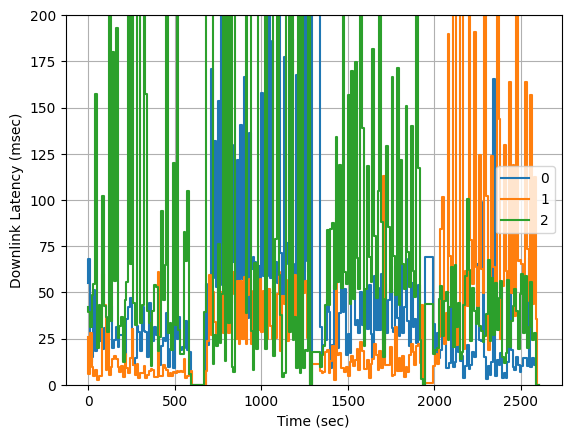

In [5]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['lat_msec'], 
             label=s_idx, where='pre')

# plt.yscale('log')
plt.ylim([0,200])

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Latency (msec)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_lat.png')

plt.show()


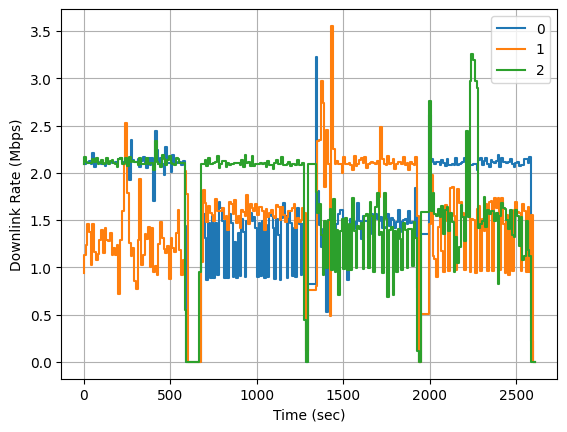

In [6]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['tx_mbps'], 
             label=s_idx, where='pre')

plt.xlabel('Time (sec)')
plt.ylabel('Downlink Rate (Mbps)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rate.png')

plt.show()

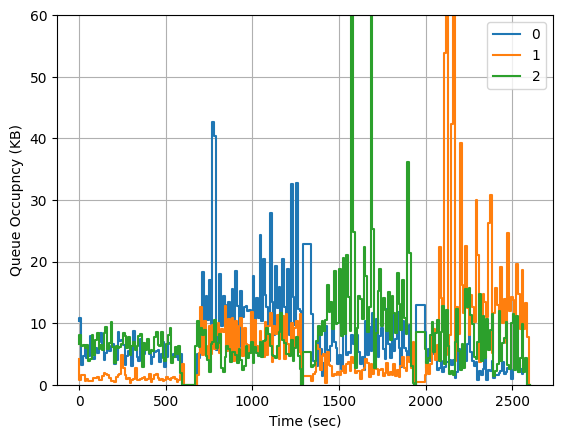

In [7]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['buf_bytes'] / 1e3, 
             label=s_idx, where='pre')

plt.ylim([0,60])

plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupncy (KB)')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_buf.png')

plt.show()

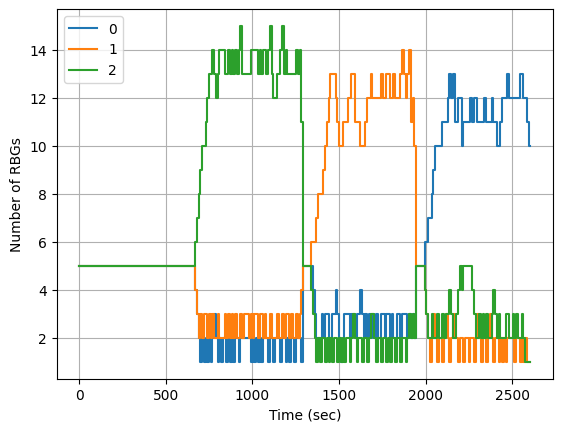

In [8]:
plt.figure()

for s_idx, metrics in data.items():
    plt.step(metrics['ts_sec'], metrics['n_rbgs'], 
             label=s_idx, where='pre')

plt.xlabel('Time (sec)')
plt.ylabel('Number of RBGs')
plt.legend()
plt.grid()

if SAVE_FIG:
    plt.savefig('../outputs/' + RESERVATION + '_rbgs.png')

plt.show()